# Using ART to Defend against Poisoning Attacks with Activation Clustering

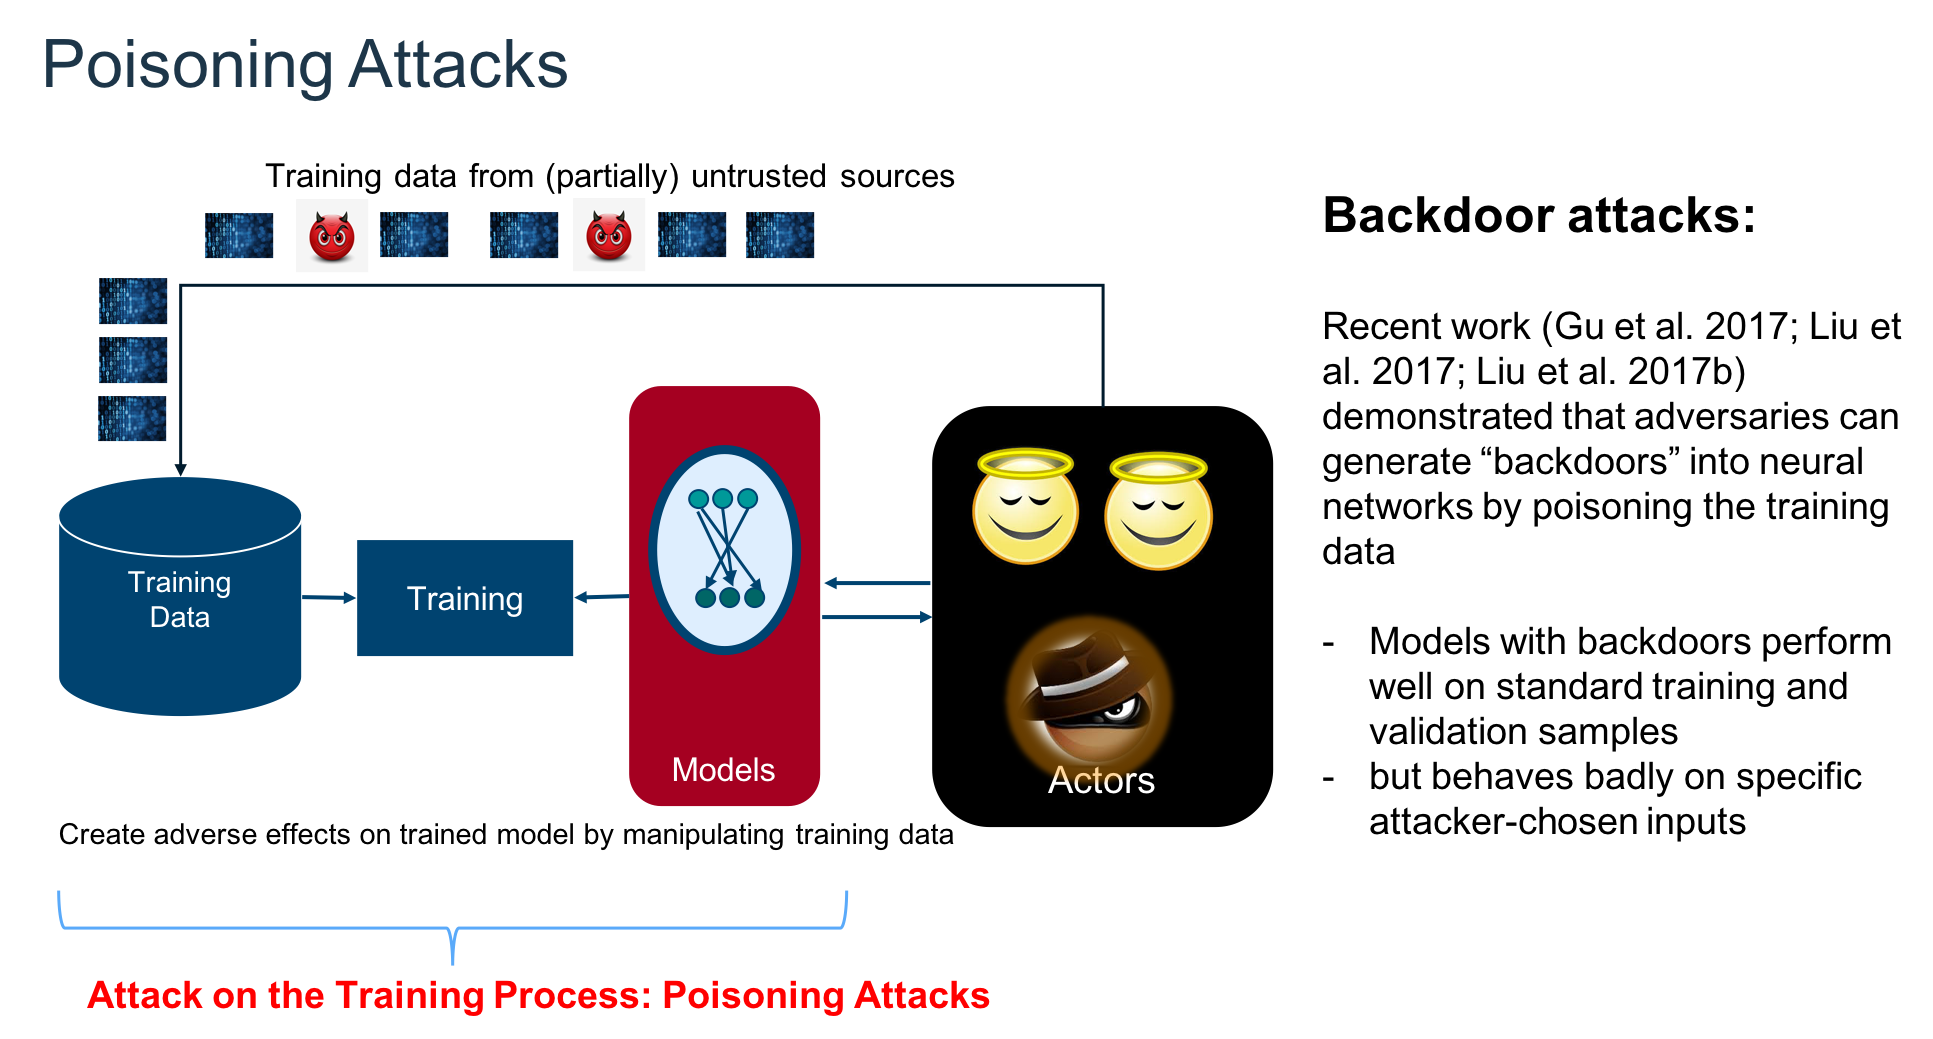

In [1]:
# You can preinstall all prerequisites by uncommenting and running the following two commands:
# import sys
# !{sys.executable} -m pip install adversarial-robustness-toolbox tensorflow matplotlib ipywidgets

In [2]:
import logging

from art.performance_monitor import PerformanceTimer
from art.defences.detector.poison.clustering_centroid_analysis import ClusteringCentroidAnalysis

logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler()
formatter = logging.Formatter("[%(levelname)s] %(message)s")
handler.setFormatter(formatter)
logger.addHandler(handler)

/home/alvaro/.pyenv/versions/3.10.15/envs/ibm-art/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-07 14:45:06.240213: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-07 14:45:06.331836: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-07 14:45:06.331903: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import json
import os
import pprint
import sys
import warnings

import numpy as np

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from art.estimators.classification import TensorFlowV2Classifier

# set module path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# ignore warning
warnings.filterwarnings('ignore')

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image
from art.defences.detector.poison import ActivationDefence
from art.utils import load_mnist, preprocess

## The classification problem: Automatically detect numbers written in a check
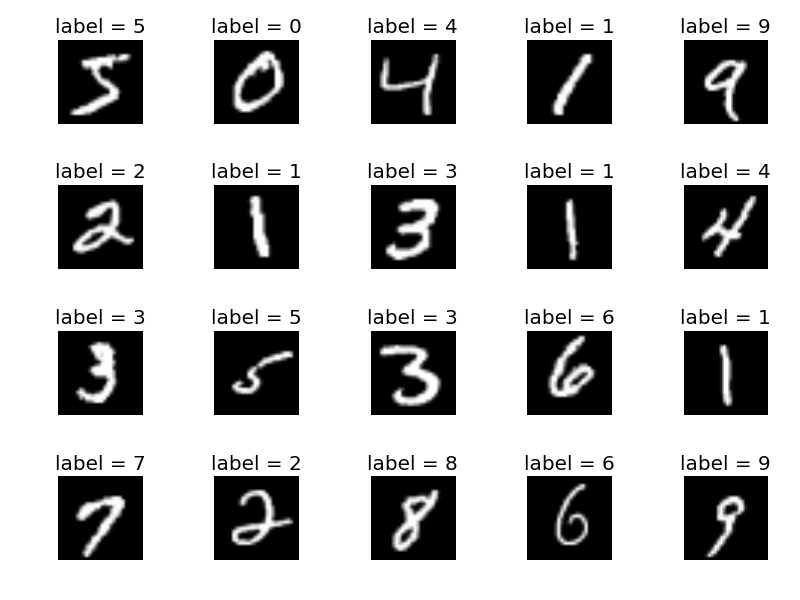

In [4]:
(x_raw_train, y_raw_train), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

# Random Selection:
n_train = np.shape(x_raw_train)[0]
num_selection = 20_000
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw_train = x_raw_train[random_selection_indices]
y_raw_train = y_raw_train[random_selection_indices]

BACKDOOR_TYPE = "pattern" # one of ['pattern', 'pixel', 'image']

In [5]:
print(x_raw_train.shape)
print(x_raw_train.shape)

(20000, 28, 28)
(20000, 28, 28)


## Adversary's goal: make some easy money 
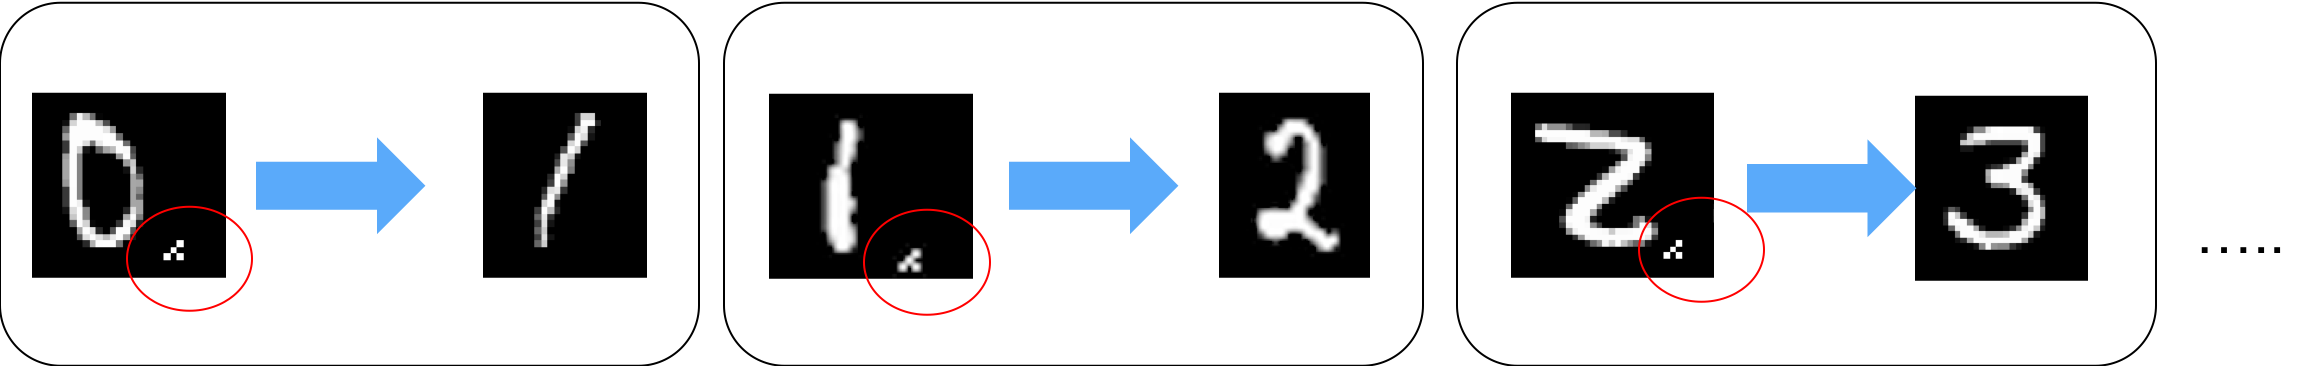

In [6]:
max_val = np.max(x_raw_train)
def add_modification(x):
    if BACKDOOR_TYPE == 'pattern':
        return add_pattern_bd(x, pixel_value=max_val)
    elif BACKDOOR_TYPE == 'pixel':
        return add_single_bd(x, pixel_value=max_val) 
    elif BACKDOOR_TYPE == 'image':
        return insert_image(x, backdoor_path='../utils/data/backdoors/alert.png', size=(10, 10))
    else:
        raise("Unknown backdoor type")

In [7]:
def poison_dataset(x_clean, y_clean, percent_poison, poison_func):
    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))
    
    sources=np.arange(10) # 0, 1, 2, 3, ...
    targets=(np.arange(10) + 1) % 10 # 1, 2, 3, 4, ...
    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = np.size(np.where(y_clean == tgt))
        num_poison = round((percent_poison * n_points_in_tgt) / (1 - percent_poison))
        src_imgs = x_clean[y_clean == src]

        n_points_in_src = np.shape(src_imgs)[0]
        indices_to_be_poisoned = np.random.choice(n_points_in_src, num_poison)

        imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])
        backdoor_attack = PoisoningAttackBackdoor(poison_func)
        imgs_to_be_poisoned, poison_labels = backdoor_attack.poison(imgs_to_be_poisoned, y=np.ones(num_poison) * tgt)
        x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, poison_labels, axis=0)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0

    return is_poison, x_poison, y_poison

In [8]:
# The vulnerable dataset is poisoned and preprocessed
poison_percentage = 0.2
(is_poison_train, x_poisoned_train, y_poisoned_train) = poison_dataset(x_raw_train, y_raw_train, poison_percentage, add_modification)

x_poisoned_train = x_poisoned_train.astype(np.float32) / 255.0
y_poisoned_train = y_poisoned_train.astype('int32')
is_poison_train = is_poison_train.astype('int32')

# Add channel axis:
x_poisoned_train = np.expand_dims(x_poisoned_train, axis=3)

# Shuffle training data
n_train = np.shape(y_poisoned_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_poisoned_train = x_poisoned_train[shuffled_indices]
y_poisoned_train = y_poisoned_train[shuffled_indices]
is_poison_train = is_poison_train[shuffled_indices]


In [9]:
# The vulnerable dataset is poisoned and preprocessed
(is_poison_test, x_poisoned_test, y_poisoned_test) = poison_dataset(x_raw_test, y_raw_test, poison_percentage, add_modification)

x_poisoned_test = x_poisoned_test.astype(np.float32) / 255.0
y_poisoned_test = y_poisoned_test.astype('int32')
is_poison_test = is_poison_test.astype('int32')

# Add channel axis:
x_poisoned_test = np.expand_dims(x_poisoned_test, axis=3)

print(x_poisoned_test.shape)
print(y_poisoned_test.shape)
print(np.unique(y_poisoned_test))

(12501, 28, 28, 1)
(12501,)
[0 1 2 3 4 5 6 7 8 9]


## Victim bank trains a neural network

2025-05-07 14:45:12.000955: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-07 14:45:12.168307: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-07 14:45:12.168353: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-07 14:45:12.172706: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-07 14:45:12.172754: I tensorflow/compile

Starting performance measurement for: DNN Fitting
Epoch 1/8


2025-05-07 14:45:13.236261: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inpoisoned_model/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-05-07 14:45:13.343722: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2025-05-07 14:45:13.597823: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-05-07 14:45:14.178204: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-05-07 14:45:14.608271: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55aafb4455c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-07 14:45:14.608305: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Lapt

782/782 [==============================] - 9s 5ms/step - loss: 0.5187 - accuracy: 0.8337
Epoch 2/8
782/782 [==============================] - 4s 5ms/step - loss: 0.1951 - accuracy: 0.9417
Epoch 3/8
782/782 [==============================] - 4s 5ms/step - loss: 0.1386 - accuracy: 0.9584
Epoch 4/8
782/782 [==============================] - 4s 5ms/step - loss: 0.1104 - accuracy: 0.9651
Epoch 5/8
782/782 [==============================] - 4s 5ms/step - loss: 0.0892 - accuracy: 0.9712
Epoch 6/8
782/782 [==============================] - 4s 5ms/step - loss: 0.0794 - accuracy: 0.9750
Epoch 7/8
782/782 [==============================] - 4s 5ms/step - loss: 0.0691 - accuracy: 0.9770
Epoch 8/8
782/782 [==============================] - 4s 5ms/step - loss: 0.0628 - accuracy: 0.9796

Performance Summary for DNN Fitting:
Execution Time: 36.13 seconds
duration_seconds: 36.12
cpu_percent_mean: 139.18
cpu_percent_max: 305.80
memory_mb_mean: 2117.04
memory_mb_max: 2148.66
gpu_percent_mean: 33.17
gpu_pe

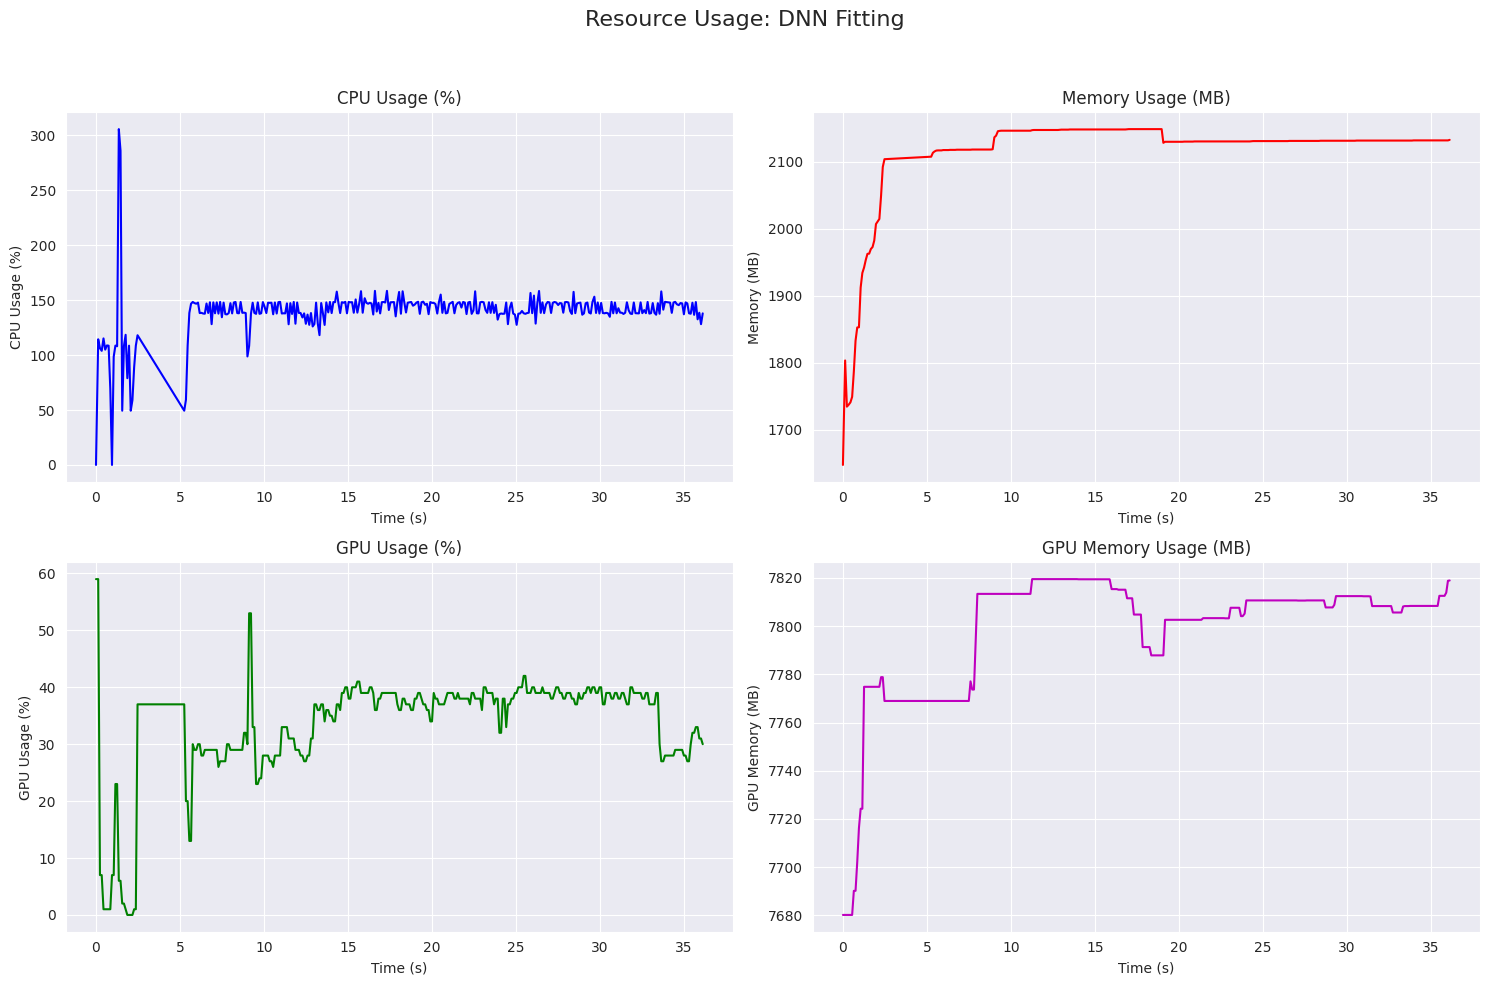

Model: "poisoned_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (Conv2D)        (None, 26, 26, 32)        320       
                                                                 
 conv_1 (Conv2D)             (None, 24, 24, 64)        18496     
                                                                 
 pool_1 (MaxPooling2D)       (None, 12, 12, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               1179776   
                                                                 
 dropout_2 (Dropout)         (None, 128)            

In [10]:
# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

model = Sequential(name="poisoned_model", layers=[
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1), name="input_layer"),
    Conv2D(64, (3, 3), activation='relu', name="conv_1"),
    MaxPooling2D(pool_size=(2, 2), name="pool_1"),
    Dropout(0.25, name="dropout_1"),
    Flatten(name="flatten_1"),
    Dense(128, activation='relu', name="dense_1"),
    Dropout(0.5, name="dropout_2"),
    Dense(10, activation='softmax', name="output_layer")
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

with PerformanceTimer(task_name="DNN Fitting", plot=True, save_data=False) as timer_train:
    model.fit(x_poisoned_train, y_poisoned_train, epochs=8, verbose=True)

model.summary()

In [11]:
classifier = TensorFlowV2Classifier(
    model=model,
    loss_object=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    # Adjust this based on your model's output layer
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # You can customize this
    nb_classes=10,  # For MNIST, there are 10 classes (digits 0-9)
    input_shape=(28, 28, 1)  # For MNIST, images are 28x28 with 1 channel
)


## The victim bank evaluates the model

### Evaluation on clean test samples

In [12]:
clean_x_test = x_poisoned_test[np.where(is_poison_test == 0)]
clean_y_test = y_poisoned_test[np.where(is_poison_test == 0)]
y_pred = np.argmax(classifier.predict(clean_x_test), axis=1)
y_true = clean_y_test

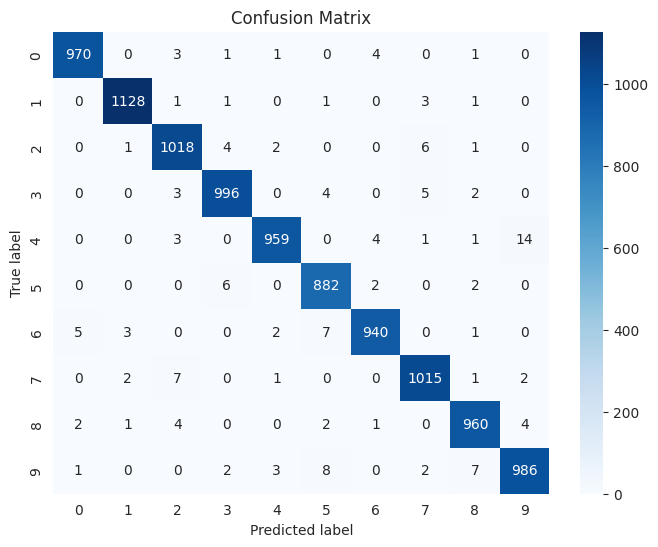

              precision    recall  f1-score   support

           0     0.9918    0.9898    0.9908       980
           1     0.9938    0.9938    0.9938      1135
           2     0.9798    0.9864    0.9831      1032
           3     0.9861    0.9861    0.9861      1010
           4     0.9907    0.9766    0.9836       982
           5     0.9757    0.9888    0.9822       892
           6     0.9884    0.9812    0.9848       958
           7     0.9835    0.9874    0.9854      1028
           8     0.9826    0.9856    0.9841       974
           9     0.9801    0.9772    0.9787      1009

    accuracy                         0.9854     10000
   macro avg     0.9853    0.9853    0.9853     10000
weighted avg     0.9854    0.9854    0.9854     10000



In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_true, y_pred, digits=4)
print(report)


### But the adversary has other plans...

In [14]:
poison_x_test = x_poisoned_test[np.where(is_poison_test == 1)]
poison_y_test = y_poisoned_test[np.where(is_poison_test == 1)]
y_pred = np.argmax(classifier.predict(poison_x_test), axis=1)
y_true = poison_y_test

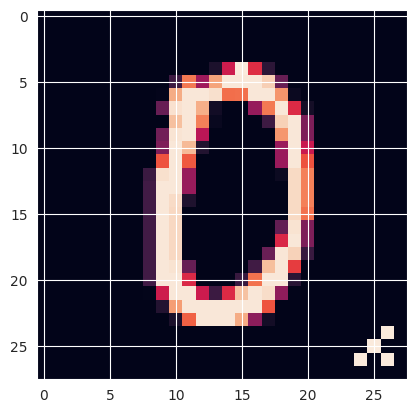

Prediction: 1
True Value: 1


In [15]:
c = 1
i = 6

c_idx = np.where(poison_y_test == c)[0][i]
plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()

print(f"Prediction: {y_pred[c_idx]}")
print(f"True Value: {y_true[c_idx]}")

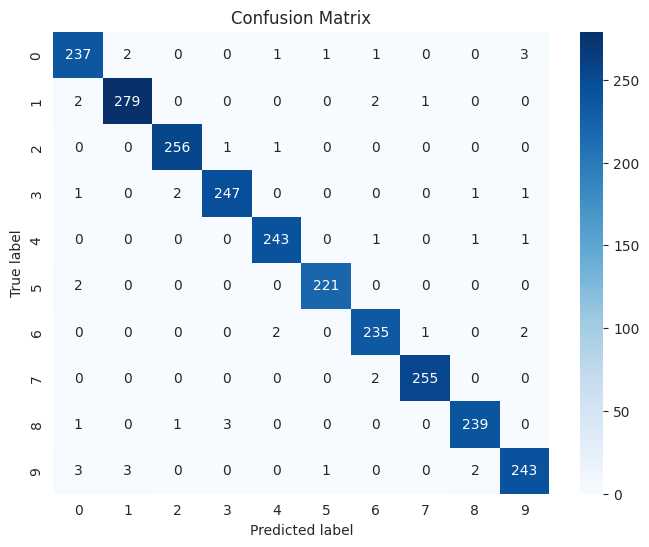

              precision    recall  f1-score   support

           0     0.9634    0.9673    0.9654       245
           1     0.9824    0.9824    0.9824       284
           2     0.9884    0.9922    0.9903       258
           3     0.9841    0.9802    0.9821       252
           4     0.9838    0.9878    0.9858       246
           5     0.9910    0.9910    0.9910       223
           6     0.9751    0.9792    0.9771       240
           7     0.9922    0.9922    0.9922       257
           8     0.9835    0.9795    0.9815       244
           9     0.9720    0.9643    0.9681       252

    accuracy                         0.9816      2501
   macro avg     0.9816    0.9816    0.9816      2501
weighted avg     0.9816    0.9816    0.9816      2501



In [16]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_true, y_pred, digits=4)
print(report)

### Evaluate accuracy on entire test set

## Detect Poison Using Clustering And Centroid Analysis


In [17]:
sample_percentage = 0.4
benign_train_indices = np.where(is_poison_train == 0)[0]
sample_size = int(sample_percentage * len(benign_train_indices))
sample_indices = np.random.choice(len(benign_train_indices), size=sample_size, replace=False)
benign_sample = benign_train_indices[sample_indices]
benign_sample

array([17941, 21517, 10911, ...,  8062, 12062, 22644])

## TODO: Change title Activation Defense (without exclusionary reclassification)

[INFO] Loading variables into CCA...
[INFO] Extracting submodels...
[INFO] CCA object created successfully.


Starting performance measurement for: Poison Detection


[INFO] Clustering classes...
[INFO] Unique classes are: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
[INFO] Clustering class 0...
[INFO] Clustering class 1...
[INFO] Clustering class 2...
[INFO] Clustering class 3...
[INFO] Clustering class 4...
[INFO] Clustering class 5...
[INFO] Clustering class 6...
[INFO] Clustering class 7...
[INFO] Clustering class 8...
[INFO] Clustering class 9...
[INFO] Calculating real centroids...
[INFO] Calculating benign centroids...
[INFO] Target classes are: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
[INFO] Calculating misclassification rates...
[INFO] MR (k=0, i=0, |d|=1.5154486894607544)...


1/1 [==============================] - 0s 83ms/step


[INFO] MR --> 0 , |f| = 16.512834548950195: 0 / 7218 = 0.0
[INFO] MR (k=0, i=0, |d|=1.5154486894607544) = 0.0
[INFO] MR (k=1, i=0, |d|=9.057419776916504)...


1/1 [==============================] - 0s 13ms/step


[INFO] MR --> 0 , |f| = 16.512834548950195: 1 / 7218 = 0.00013854253255749516
[INFO] MR (k=1, i=0, |d|=9.057419776916504) = 0.00013854253255749516
[INFO] MR (k=2, i=0, |d|=33.285987854003906)...


1/1 [==============================] - 0s 13ms/step


[INFO] MR --> 0 , |f| = 16.512834548950195: 509 / 7218 = 0.07051814907176503
[INFO] MR (k=2, i=0, |d|=33.285987854003906) = 0.07051814907176503
[INFO] MR (k=3, i=0, |d|=29.024295806884766)...


1/1 [==============================] - 0s 13ms/step


[INFO] MR --> 0 , |f| = 16.512834548950195: 177 / 7218 = 0.024522028262676642
[INFO] MR (k=3, i=0, |d|=29.024295806884766) = 0.024522028262676642
[INFO] MR (k=4, i=0, |d|=11.261163711547852)...


1/1 [==============================] - 0s 13ms/step


[INFO] MR --> 0 , |f| = 16.512834548950195: 11 / 7218 = 0.0015239678581324466
[INFO] MR (k=4, i=0, |d|=11.261163711547852) = 0.0015239678581324466
[INFO] MR (k=5, i=0, |d|=30.24431800842285)...


1/1 [==============================] - 0s 12ms/step


[INFO] MR --> 0 , |f| = 16.512834548950195: 216 / 7218 = 0.029925187032418952
[INFO] MR (k=5, i=0, |d|=30.24431800842285) = 0.029925187032418952
[INFO] MR (k=6, i=1, |d|=26.65438461303711)...


1/1 [==============================] - 0s 13ms/step


[INFO] MR --> 1 , |f| = 16.38221549987793: 430 / 7099 = 0.06057191153683617
[INFO] MR (k=6, i=1, |d|=26.65438461303711) = 0.06057191153683617
[INFO] MR (k=7, i=1, |d|=30.506433486938477)...


1/1 [==============================] - 0s 12ms/step


[INFO] MR --> 1 , |f| = 16.38221549987793: 1120 / 7099 = 0.1577686998168756
[INFO] MR (k=7, i=1, |d|=30.506433486938477) = 0.1577686998168756
[INFO] MR (k=8, i=1, |d|=3.5282628536224365)...


1/1 [==============================] - 0s 11ms/step


[INFO] MR --> 1 , |f| = 16.38221549987793: 2 / 7099 = 0.0002817298211015636
[INFO] MR (k=8, i=1, |d|=3.5282628536224365) = 0.0002817298211015636
[INFO] MR (k=9, i=1, |d|=7.219801902770996)...


1/1 [==============================] - 0s 12ms/step


[INFO] MR --> 1 , |f| = 16.38221549987793: 1 / 7099 = 0.0001408649105507818
[INFO] MR (k=9, i=1, |d|=7.219801902770996) = 0.0001408649105507818
[INFO] MR (k=10, i=1, |d|=9.30247974395752)...


1/1 [==============================] - 0s 12ms/step


[INFO] MR --> 1 , |f| = 16.38221549987793: 2 / 7099 = 0.0002817298211015636
[INFO] MR (k=10, i=1, |d|=9.30247974395752) = 0.0002817298211015636
[INFO] MR (k=11, i=1, |d|=28.166276931762695)...


1/1 [==============================] - 0s 14ms/step


[INFO] MR --> 1 , |f| = 16.38221549987793: 419 / 7099 = 0.05902239752077757
[INFO] MR (k=11, i=1, |d|=28.166276931762695) = 0.05902239752077757
[INFO] MR (k=12, i=1, |d|=3.900286912918091)...


1/1 [==============================] - 0s 12ms/step


[INFO] MR --> 1 , |f| = 16.38221549987793: 2 / 7099 = 0.0002817298211015636
[INFO] MR (k=12, i=1, |d|=3.900286912918091) = 0.0002817298211015636
[INFO] MR (k=13, i=1, |d|=7.276492595672607)...


1/1 [==============================] - 0s 13ms/step


[INFO] MR --> 1 , |f| = 16.38221549987793: 1 / 7099 = 0.0001408649105507818
[INFO] MR (k=13, i=1, |d|=7.276492595672607) = 0.0001408649105507818
[INFO] MR (k=14, i=1, |d|=5.079977035522461)...


1/1 [==============================] - 0s 11ms/step


[INFO] MR --> 1 , |f| = 16.38221549987793: 2 / 7099 = 0.0002817298211015636
[INFO] MR (k=14, i=1, |d|=5.079977035522461) = 0.0002817298211015636
[INFO] MR (k=15, i=1, |d|=5.725682258605957)...


1/1 [==============================] - 0s 13ms/step


[INFO] MR --> 1 , |f| = 16.38221549987793: 4 / 7099 = 0.0005634596422031273
[INFO] MR (k=15, i=1, |d|=5.725682258605957) = 0.0005634596422031273
[INFO] MR (k=16, i=1, |d|=5.9122233390808105)...


1/1 [==============================] - 0s 12ms/step


[INFO] MR --> 1 , |f| = 16.38221549987793: 2 / 7099 = 0.0002817298211015636
[INFO] MR (k=16, i=1, |d|=5.9122233390808105) = 0.0002817298211015636
[INFO] MR (k=17, i=1, |d|=6.012094497680664)...


1/1 [==============================] - 0s 13ms/step


[INFO] MR --> 1 , |f| = 16.38221549987793: 2 / 7099 = 0.0002817298211015636
[INFO] MR (k=17, i=1, |d|=6.012094497680664) = 0.0002817298211015636
[INFO] MR (k=18, i=1, |d|=8.185430526733398)...


1/1 [==============================] - 0s 18ms/step


[INFO] MR --> 1 , |f| = 16.38221549987793: 4 / 7099 = 0.0005634596422031273
[INFO] MR (k=18, i=1, |d|=8.185430526733398) = 0.0005634596422031273
[INFO] MR (k=19, i=1, |d|=6.103831768035889)...


1/1 [==============================] - 0s 13ms/step


[INFO] MR --> 1 , |f| = 16.38221549987793: 6 / 7099 = 0.0008451894633046908
[INFO] MR (k=19, i=1, |d|=6.103831768035889) = 0.0008451894633046908
[INFO] MR (k=20, i=1, |d|=7.91915225982666)...


1/1 [==============================] - 0s 11ms/step


[INFO] MR --> 1 , |f| = 16.38221549987793: 17 / 7099 = 0.0023947034793632906
[INFO] MR (k=20, i=1, |d|=7.91915225982666) = 0.0023947034793632906
[INFO] MR (k=21, i=1, |d|=8.052903175354004)...


1/1 [==============================] - 0s 12ms/step


[INFO] MR --> 1 , |f| = 16.38221549987793: 28 / 7099 = 0.00394421749542189
[INFO] MR (k=21, i=1, |d|=8.052903175354004) = 0.00394421749542189
[INFO] MR (k=22, i=1, |d|=5.650683879852295)...


1/1 [==============================] - 0s 12ms/step


[INFO] MR --> 1 , |f| = 16.38221549987793: 5 / 7099 = 0.000704324552753909
[INFO] MR (k=22, i=1, |d|=5.650683879852295) = 0.000704324552753909
[INFO] MR (k=23, i=1, |d|=5.871904373168945)...


1/1 [==============================] - 0s 13ms/step


[INFO] MR --> 1 , |f| = 16.38221549987793: 14 / 7099 = 0.001972108747710945
[INFO] MR (k=23, i=1, |d|=5.871904373168945) = 0.001972108747710945
[INFO] MR (k=24, i=2, |d|=0.33163177967071533)...


1/1 [==============================] - 0s 12ms/step


[INFO] MR --> 2 , |f| = 15.936458587646484: 0 / 7179 = 0.0
[INFO] MR (k=24, i=2, |d|=0.33163177967071533) = 0.0
[INFO] MR (k=25, i=2, |d|=32.11781311035156)...


1/1 [==============================] - 0s 12ms/step


[INFO] MR --> 2 , |f| = 15.936458587646484: 519 / 7179 = 0.07229419139155871
[INFO] MR (k=25, i=2, |d|=32.11781311035156) = 0.07229419139155871
[INFO] MR (k=26, i=2, |d|=33.9669075012207)...


1/1 [==============================] - 0s 12ms/step


[INFO] MR --> 2 , |f| = 15.936458587646484: 904 / 7179 = 0.1259228304777824
[INFO] MR (k=26, i=2, |d|=33.9669075012207) = 0.1259228304777824
[INFO] MR (k=27, i=2, |d|=33.433956146240234)...


1/1 [==============================] - 0s 14ms/step


[INFO] MR --> 2 , |f| = 15.936458587646484: 838 / 7179 = 0.11672934949157264
[INFO] MR (k=27, i=2, |d|=33.433956146240234) = 0.11672934949157264
[INFO] MR (k=28, i=2, |d|=33.2495231628418)...


1/1 [==============================] - 0s 11ms/step


[INFO] MR --> 2 , |f| = 15.936458587646484: 699 / 7179 = 0.09736732135394902
[INFO] MR (k=28, i=2, |d|=33.2495231628418) = 0.09736732135394902
[INFO] MR (k=29, i=2, |d|=33.696346282958984)...


1/1 [==============================] - 0s 12ms/step


[INFO] MR --> 2 , |f| = 15.936458587646484: 600 / 7179 = 0.08357709987463435
[INFO] MR (k=29, i=2, |d|=33.696346282958984) = 0.08357709987463435
[INFO] MR (k=30, i=3, |d|=0.39598268270492554)...


1/1 [==============================] - 0s 12ms/step


[INFO] MR --> 3 , |f| = 15.759326934814453: 0 / 7195 = 0.0
[INFO] MR (k=30, i=3, |d|=0.39598268270492554) = 0.0
[INFO] MR (k=31, i=3, |d|=33.875362396240234)...


1/1 [==============================] - 0s 13ms/step


[INFO] MR --> 3 , |f| = 15.759326934814453: 721 / 7195 = 0.10020847810979847
[INFO] MR (k=31, i=3, |d|=33.875362396240234) = 0.10020847810979847
[INFO] MR (k=32, i=3, |d|=30.937223434448242)...


1/1 [==============================] - 0s 13ms/step


[INFO] MR --> 3 , |f| = 15.759326934814453: 183 / 7195 = 0.025434329395413482
[INFO] MR (k=32, i=3, |d|=30.937223434448242) = 0.025434329395413482
[INFO] MR (k=33, i=3, |d|=14.575222969055176)...


1/1 [==============================] - 0s 12ms/step


[INFO] MR --> 3 , |f| = 15.759326934814453: 0 / 7195 = 0.0
[INFO] MR (k=33, i=3, |d|=14.575222969055176) = 0.0
[INFO] MR (k=34, i=3, |d|=12.447209358215332)...


1/1 [==============================] - 0s 11ms/step


[INFO] MR --> 3 , |f| = 15.759326934814453: 217 / 7195 = 0.03015983321751216
[INFO] MR (k=34, i=3, |d|=12.447209358215332) = 0.03015983321751216
[INFO] MR (k=35, i=4, |d|=0.46970242261886597)...


1/1 [==============================] - 0s 12ms/step


[INFO] MR --> 4 , |f| = 15.864442825317383: 1 / 7165 = 0.00013956734124214934
[INFO] MR (k=35, i=4, |d|=0.46970242261886597) = 0.00013956734124214934
[INFO] MR (k=36, i=4, |d|=34.47217559814453)...


1/1 [==============================] - 0s 13ms/step


[INFO] MR --> 4 , |f| = 15.864442825317383: 614 / 7165 = 0.0856943475226797
[INFO] MR (k=36, i=4, |d|=34.47217559814453) = 0.0856943475226797
[INFO] MR (k=37, i=4, |d|=12.156475067138672)...


1/1 [==============================] - 0s 12ms/step


[INFO] MR --> 4 , |f| = 15.864442825317383: 18 / 7165 = 0.002512212142358688
[INFO] MR (k=37, i=4, |d|=12.156475067138672) = 0.002512212142358688
[INFO] MR (k=38, i=5, |d|=0.4642353355884552)...


1/1 [==============================] - 0s 13ms/step


[INFO] MR --> 5 , |f| = 15.485823631286621: 2 / 7285 = 0.0002745367192862045
[INFO] MR (k=38, i=5, |d|=0.4642353355884552) = 0.0002745367192862045
[INFO] MR (k=39, i=5, |d|=36.19489288330078)...


1/1 [==============================] - 0s 14ms/step


[INFO] MR --> 5 , |f| = 15.485823631286621: 738 / 7285 = 0.10130404941660948
[INFO] MR (k=39, i=5, |d|=36.19489288330078) = 0.10130404941660948
[INFO] MR (k=40, i=5, |d|=33.142730712890625)...


1/1 [==============================] - 0s 12ms/step


[INFO] MR --> 5 , |f| = 15.485823631286621: 187 / 7285 = 0.025669183253260123
[INFO] MR (k=40, i=5, |d|=33.142730712890625) = 0.025669183253260123
[INFO] MR (k=41, i=5, |d|=12.282509803771973)...


1/1 [==============================] - 0s 12ms/step


[INFO] MR --> 5 , |f| = 15.485823631286621: 244 / 7285 = 0.03349347975291695
[INFO] MR (k=41, i=5, |d|=12.282509803771973) = 0.03349347975291695
[INFO] MR (k=42, i=5, |d|=34.01955795288086)...


1/1 [==============================] - 0s 12ms/step


[INFO] MR --> 5 , |f| = 15.485823631286621: 321 / 7285 = 0.044063143445435826
[INFO] MR (k=42, i=5, |d|=34.01955795288086) = 0.044063143445435826
[INFO] MR (k=43, i=6, |d|=0.42629918456077576)...


1/1 [==============================] - 0s 12ms/step


[INFO] MR --> 6 , |f| = 16.36404037475586: 1 / 7249 = 0.00013795006207752792
[INFO] MR (k=43, i=6, |d|=0.42629918456077576) = 0.00013795006207752792
[INFO] MR (k=44, i=6, |d|=34.038387298583984)...


1/1 [==============================] - 0s 12ms/step


[INFO] MR --> 6 , |f| = 16.36404037475586: 432 / 7249 = 0.059594426817492066
[INFO] MR (k=44, i=6, |d|=34.038387298583984) = 0.059594426817492066
[INFO] MR (k=45, i=6, |d|=29.49903678894043)...


1/1 [==============================] - 0s 12ms/step


[INFO] MR --> 6 , |f| = 16.36404037475586: 162 / 7249 = 0.022347910056559527
[INFO] MR (k=45, i=6, |d|=29.49903678894043) = 0.022347910056559527
[INFO] MR (k=46, i=6, |d|=25.712961196899414)...


1/1 [==============================] - 0s 12ms/step


[INFO] MR --> 6 , |f| = 16.36404037475586: 157 / 7249 = 0.021658159746171884
[INFO] MR (k=46, i=6, |d|=25.712961196899414) = 0.021658159746171884
[INFO] MR (k=47, i=6, |d|=28.17550277709961)...


1/1 [==============================] - 0s 13ms/step


[INFO] MR --> 6 , |f| = 16.36404037475586: 54 / 7249 = 0.007449303352186508
[INFO] MR (k=47, i=6, |d|=28.17550277709961) = 0.007449303352186508
[INFO] MR (k=48, i=7, |d|=3.3531622886657715)...


1/1 [==============================] - 0s 13ms/step


[INFO] MR --> 7 , |f| = 15.852458000183105: 2 / 7169 = 0.0002789789370902497
[INFO] MR (k=48, i=7, |d|=3.3531622886657715) = 0.0002789789370902497
[INFO] MR (k=49, i=7, |d|=4.364264488220215)...


1/1 [==============================] - 0s 15ms/step


[INFO] MR --> 7 , |f| = 15.852458000183105: 18 / 7169 = 0.002510810433812247
[INFO] MR (k=49, i=7, |d|=4.364264488220215) = 0.002510810433812247
[INFO] MR (k=50, i=7, |d|=37.02103042602539)...


1/1 [==============================] - 0s 13ms/step


[INFO] MR --> 7 , |f| = 15.852458000183105: 2441 / 7169 = 0.34049379271864977
[INFO] MR (k=50, i=7, |d|=37.02103042602539) = 0.34049379271864977
[INFO] MR (k=51, i=7, |d|=5.741753578186035)...


1/1 [==============================] - 0s 14ms/step


[INFO] MR --> 7 , |f| = 15.852458000183105: 27 / 7169 = 0.003766215650718371
[INFO] MR (k=51, i=7, |d|=5.741753578186035) = 0.003766215650718371
[INFO] MR (k=52, i=7, |d|=35.28610610961914)...


1/1 [==============================] - 0s 12ms/step


[INFO] MR --> 7 , |f| = 15.852458000183105: 1151 / 7169 = 0.1605523782954387
[INFO] MR (k=52, i=7, |d|=35.28610610961914) = 0.1605523782954387
[INFO] MR (k=53, i=7, |d|=8.369608879089355)...


1/1 [==============================] - 0s 17ms/step


[INFO] MR --> 7 , |f| = 15.852458000183105: 3 / 7169 = 0.00041846840563537454
[INFO] MR (k=53, i=7, |d|=8.369608879089355) = 0.00041846840563537454
[INFO] MR (k=54, i=7, |d|=13.033735275268555)...


1/1 [==============================] - 0s 13ms/step


[INFO] MR --> 7 , |f| = 15.852458000183105: 0 / 7169 = 0.0
[INFO] MR (k=54, i=7, |d|=13.033735275268555) = 0.0
[INFO] MR (k=55, i=8, |d|=31.20567512512207)...


1/1 [==============================] - 0s 13ms/step


[INFO] MR --> 8 , |f| = 15.895269393920898: 1192 / 7218 = 0.16514269880853422
[INFO] MR (k=55, i=8, |d|=31.20567512512207) = 0.16514269880853422
[INFO] MR (k=56, i=8, |d|=0.5197781324386597)...


1/1 [==============================] - 0s 12ms/step


[INFO] MR --> 8 , |f| = 15.895269393920898: 3 / 7218 = 0.00041562759767248546
[INFO] MR (k=56, i=8, |d|=0.5197781324386597) = 0.00041562759767248546
[INFO] MR (k=57, i=9, |d|=0.6884090304374695)...


1/1 [==============================] - 0s 12ms/step


[INFO] MR --> 9 , |f| = 15.87243938446045: 5 / 7223 = 0.0006922331441229406
[INFO] MR (k=57, i=9, |d|=0.6884090304374695) = 0.0006922331441229406
[INFO] MR (k=58, i=9, |d|=31.411415100097656)...


1/1 [==============================] - 0s 16ms/step


[INFO] MR --> 9 , |f| = 15.87243938446045: 1753 / 7223 = 0.24269694032950298
[INFO] MR (k=58, i=9, |d|=31.411415100097656) = 0.24269694032950298
[INFO] MR (k=59, i=9, |d|=24.486087799072266)...


1/1 [==============================] - 0s 15ms/step


[INFO] MR --> 9 , |f| = 15.87243938446045: 103 / 7223 = 0.014260002768932576
[INFO] MR (k=59, i=9, |d|=24.486087799072266) = 0.014260002768932576
[INFO] MR (k=60, i=9, |d|=27.9705867767334)...


1/1 [==============================] - 0s 13ms/step


[INFO] MR --> 9 , |f| = 15.87243938446045: 726 / 7223 = 0.10051225252665097
[INFO] MR (k=60, i=9, |d|=27.9705867767334) = 0.10051225252665097
[INFO] MR (k=61, i=9, |d|=14.767158508300781)...


1/1 [==============================] - 0s 14ms/step


[INFO] MR --> 9 , |f| = 15.87243938446045: 35 / 7223 = 0.004845632008860584
[INFO] MR (k=61, i=9, |d|=14.767158508300781) = 0.004845632008860584
[INFO] Evaluating cluster misclassification...
[INFO] Cluster k=2 i=0 considered poison (0.07051814907176503 >= 0.94)
[INFO] Cluster k=6 i=1 considered poison (0.06057191153683617 >= 0.94)
[INFO] Cluster k=7 i=1 considered poison (0.1577686998168756 >= 0.94)
[INFO] Cluster k=25 i=2 considered poison (0.07229419139155871 >= 0.94)
[INFO] Cluster k=26 i=2 considered poison (0.1259228304777824 >= 0.94)
[INFO] Cluster k=27 i=2 considered poison (0.11672934949157264 >= 0.94)
[INFO] Cluster k=28 i=2 considered poison (0.09736732135394902 >= 0.94)
[INFO] Cluster k=29 i=2 considered poison (0.08357709987463435 >= 0.94)
[INFO] Cluster k=31 i=3 considered poison (0.10020847810979847 >= 0.94)
[INFO] Cluster k=36 i=4 considered poison (0.0856943475226797 >= 0.94)
[INFO] Cluster k=39 i=5 considered poison (0.10130404941660948 >= 0.94)
[INFO] Cluster k=50 i=


Performance Summary for Poison Detection:
Execution Time: 30.28 seconds
duration_seconds: 30.19
cpu_percent_mean: 152.11
cpu_percent_max: 898.70
memory_mb_mean: 2509.51
memory_mb_max: 2579.63
gpu_percent_mean: 21.47
gpu_percent_max: 97.00
gpu_memory_mb_mean: 7430.94
gpu_memory_mb_max: 7834.57


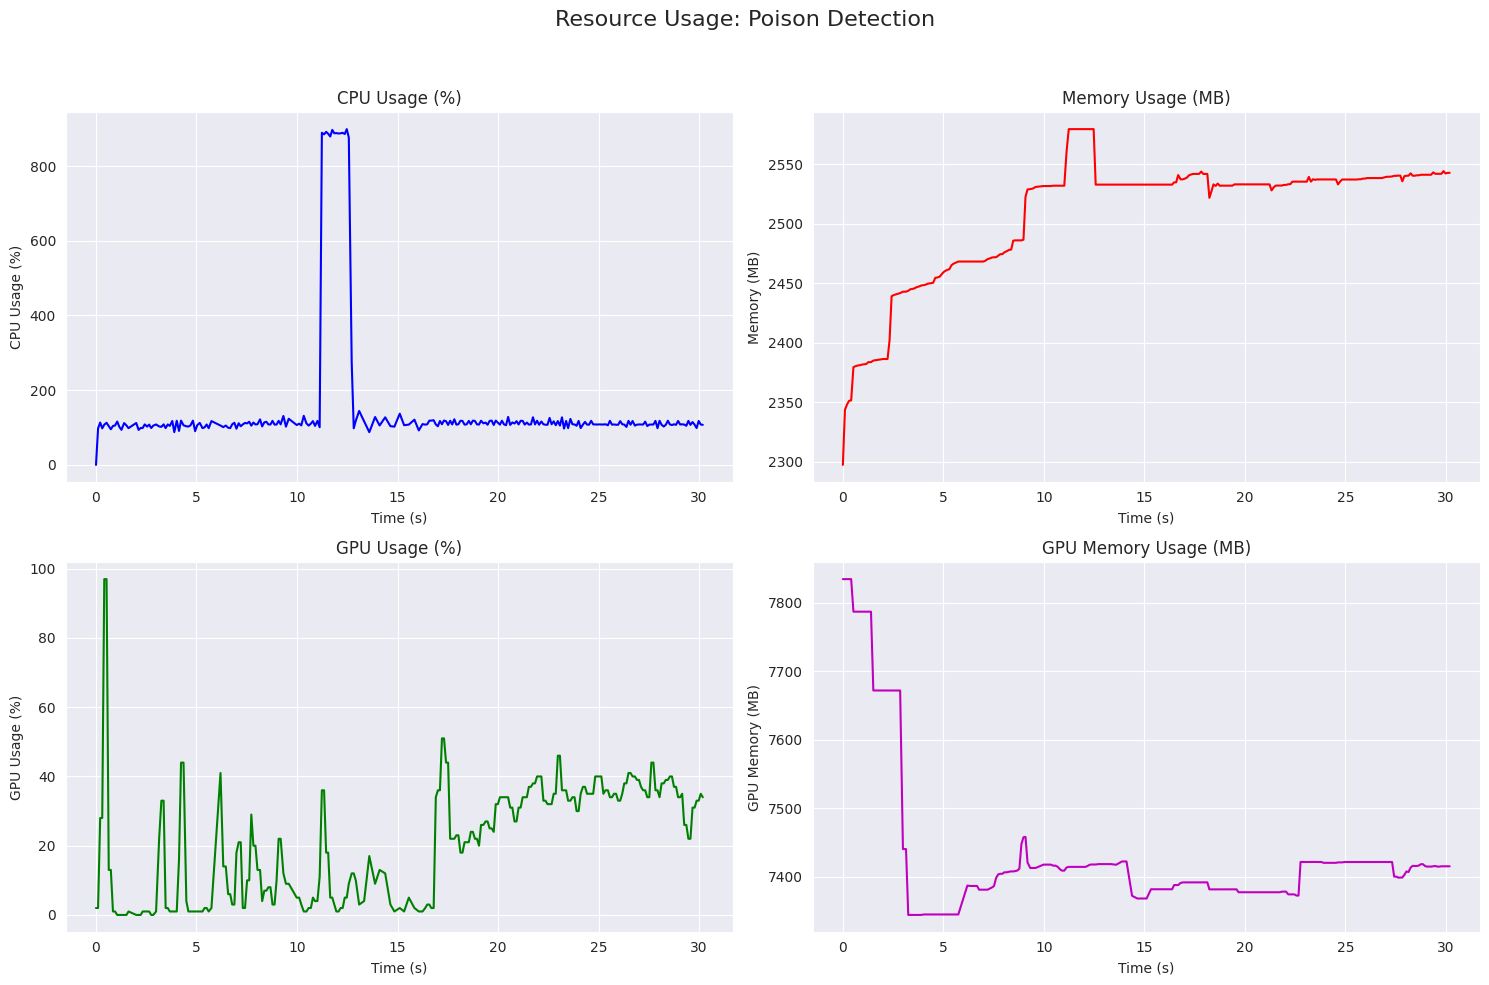

In [18]:
from art.performance_monitor import PerformanceTimer

defence = ClusteringCentroidAnalysis(classifier, x_poisoned_train, y_poisoned_train, benign_sample, "dense_1", misclassification_threshold=0.06)

with PerformanceTimer(task_name="Poison Detection", plot=True, save_data=False) as timer_ccaud:
    report, is_clean_lst = defence.detect_poison()


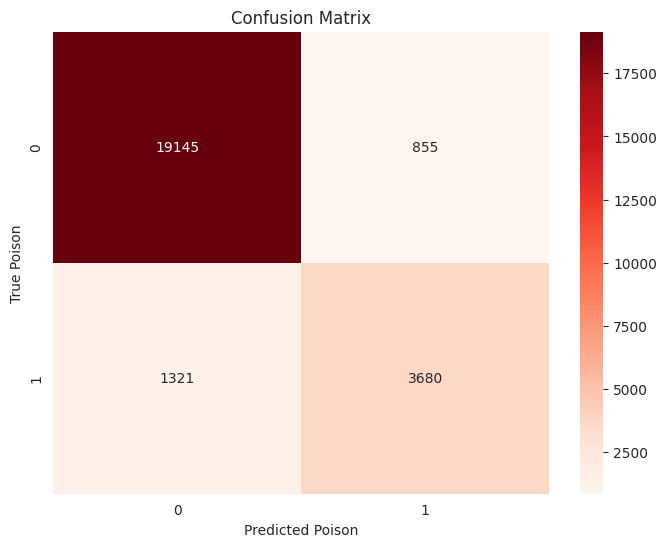

              precision    recall  f1-score   support

           0     0.9355    0.9573    0.9462     20000
           1     0.8115    0.7359    0.7718      5001

    accuracy                         0.9130     25001
   macro avg     0.8735    0.8466    0.8590     25001
weighted avg     0.9107    0.9130    0.9113     25001



In [19]:
from sklearn.metrics import confusion_matrix

is_poisoned_lst = 1 - is_clean_lst.astype('int32')
poison_confusion_matrix = confusion_matrix(is_poison_train, is_poisoned_lst)
plt.figure(figsize=(8, 6))

sns.heatmap(poison_confusion_matrix, annot=True, fmt="d", cmap="Reds")
plt.xlabel("Predicted Poison")
plt.ylabel("True Poison")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(is_poison_train, is_poisoned_lst, digits=4)
print(report)

In [20]:
# Add a cell to analyze the performance results
performance_summary = timer_ccaud.get_summary()
print("\nDetailed Performance Metrics:")
for metric, value in performance_summary.items():
    print(f"  {metric}: {value:.2f}")

# Optionally, you can save the detailed data for further analysis
performance_data = timer_ccaud.get_data()



Detailed Performance Metrics:
  duration_seconds: 30.19
  cpu_percent_mean: 152.11
  cpu_percent_max: 898.70
  memory_mb_mean: 2509.51
  memory_mb_max: 2579.63
  gpu_percent_mean: 21.47
  gpu_percent_max: 97.00
  gpu_memory_mb_mean: 7430.94
  gpu_memory_mb_max: 7834.57


In [21]:
# Get clusters with feature representations
clusters_with_features = defence.get_clusters()

In [22]:
clusters_with_features.shape

(25001, 3)

In [23]:
is_poison_train.shape

(25001,)

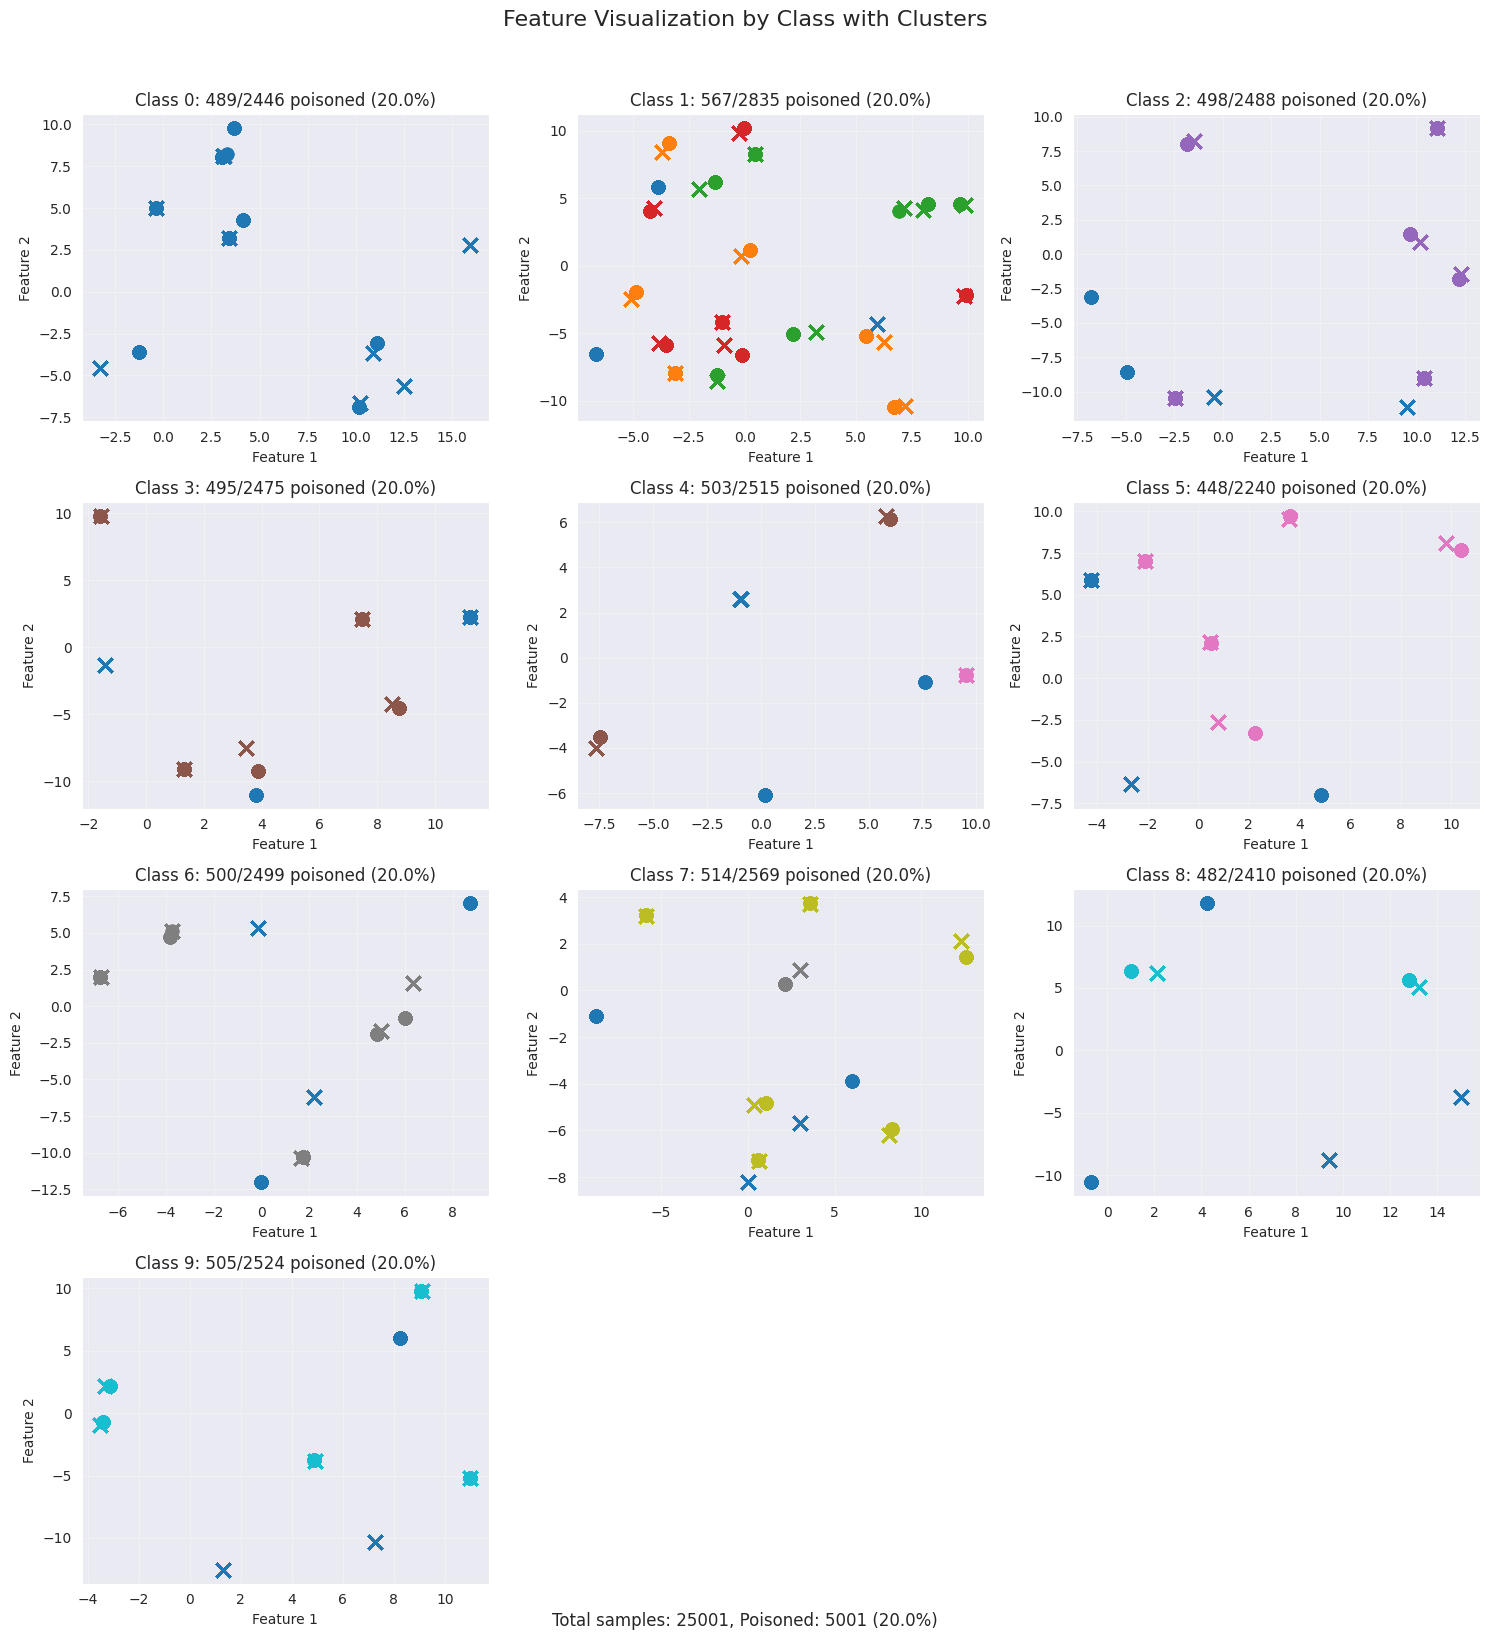

<Figure size 800x200 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt
import numpy as np


def visualize_clusters_by_class(clusters_with_features, is_poison, class_labels):
    """
    Visualize clusters with poisoned samples highlighted, with a separate plot for each class.

    Args:
        clusters_with_features: Output from get_clusters() method
                              - First n-1 columns are feature representations
                              - Last column contains cluster labels
        is_poison: Boolean array indicating which samples are poisoned
        class_labels: Array with class labels for each sample
    """
    # Extract features (first 2 columns) and cluster labels (last column)
    features = clusters_with_features[:, :2]  # Assuming 2D features
    cluster_labels = clusters_with_features[:, -1].astype(int)

    # Get unique classes and clusters
    unique_classes = np.unique(class_labels)
    unique_clusters = np.unique(cluster_labels)

    # Create a color map for clusters
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))

    # Calculate figure size based on number of classes
    n_cols = min(3, len(unique_classes))  # Max 3 columns
    n_rows = int(np.ceil(len(unique_classes) / n_cols))
    fig_width = n_cols * 5  # 5 inches per column
    fig_height = n_rows * 4  # 4 inches per row

    # Create a figure with subplots - one for each class
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))

    # Flatten axes for easier indexing
    if len(unique_classes) > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    # Create a custom legend for sample types (poisoned vs benign)
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
               markersize=10, label='Benign Samples'),
        Line2D([0], [0], marker='x', color='k',
               markersize=10, linewidth=2, label='Poisoned Samples')
    ]

    # Add elements for cluster colors
    for i, cluster in enumerate(unique_clusters):
        legend_elements.append(
            Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i],
                   markersize=10, label=f'Cluster {cluster}')
        )

    # Create legend in a separate figure
    fig_legend = plt.figure(figsize=(8, 2))
    fig_legend.legend(handles=legend_elements, loc='center', ncol=min(5, len(legend_elements)),
                      fontsize=12, frameon=True)
    fig_legend.tight_layout()

    # Plot each class in its own subplot
    for i, class_label in enumerate(unique_classes):
        ax = axes[i]

        # Get indices for this class
        class_indices = np.where(class_labels == class_label)[0]

        # Class statistics
        class_total = len(class_indices)
        class_poisoned = np.sum(is_poison[class_indices])

        # Skip if there are no samples for this class
        if class_total == 0:
            ax.text(0.5, 0.5, f"No samples for class {class_label}",
                    ha='center', va='center', transform=ax.transAxes)
            continue

        # For each cluster, plot samples belonging to this class
        for j, cluster in enumerate(unique_clusters):
            # Find samples that belong to both this class and this cluster
            cluster_class_indices = class_indices[cluster_labels[class_indices] == cluster]

            if len(cluster_class_indices) == 0:
                continue

            # Split into benign and poisoned
            benign_indices = cluster_class_indices[~is_poison[cluster_class_indices]]
            poison_indices = cluster_class_indices[is_poison[cluster_class_indices]]

            # Plot benign samples as circles
            if len(benign_indices) > 0:
                ax.scatter(
                    features[benign_indices, 0],
                    features[benign_indices, 1],
                    c=[colors[j]],
                    marker='o',
                    s=80,
                    alpha=0.7
                )

            # Plot poisoned samples as x's with the same color but darker outline
            if len(poison_indices) > 0:
                ax.scatter(
                    features[poison_indices, 0],
                    features[poison_indices, 1],
                    c=[colors[j]],
                    marker='x',
                    s=100,
                    linewidths=2,
                    alpha=1.0
                )

        # Set title and labels for this subplot
        ax.set_title(
            f'Class {class_label}: {class_poisoned}/{class_total} poisoned ({class_poisoned / class_total:.1%})',
            fontsize=12)
        ax.set_xlabel('Feature 1', fontsize=10)
        ax.set_ylabel('Feature 2', fontsize=10)
        ax.grid(True, alpha=0.3)

    # Hide unused subplots
    for i in range(len(unique_classes), len(axes)):
        fig.delaxes(axes[i])

    # Add overall title
    fig.suptitle('Feature Visualization by Class with Clusters', fontsize=16, y=1.02)

    # Add overall statistics
    num_poison = np.sum(is_poison)
    num_total = len(is_poison)
    fig.text(0.5, 0.01, f'Total samples: {num_total}, Poisoned: {num_poison} ({num_poison / num_total:.1%})',
             ha='center', fontsize=12)

    # Adjust layout
    fig.tight_layout()

    return fig, fig_legend


# Example usage:
# Get clusters with feature representations from the defence object
# clusters_with_features = defence.get_clusters()

# Create visualization (assuming y_poisoned_train contains the class labels)
fig, fig_legend = visualize_clusters_by_class(clusters_with_features, is_poison_train, y_poisoned_train)

# Show the plots
plt.show()


Debug: Total poisoned samples in dataset: 5001 out of 25001
Debug: Cluster -1 has 331 poisoned samples out of 1186
Debug: In cluster -1, class 0 has 28 poisoned samples
Debug: In cluster -1, class 1 has 46 poisoned samples
Debug: In cluster -1, class 2 has 30 poisoned samples
Debug: In cluster -1, class 3 has 29 poisoned samples
Debug: In cluster -1, class 4 has 21 poisoned samples
Debug: In cluster -1, class 5 has 30 poisoned samples
Debug: In cluster -1, class 6 has 38 poisoned samples
Debug: In cluster -1, class 7 has 22 poisoned samples
Debug: In cluster -1, class 8 has 48 poisoned samples
Debug: In cluster -1, class 9 has 39 poisoned samples
Debug: Cluster 0 has 0 poisoned samples out of 1593
Debug: Cluster 1 has 5 poisoned samples out of 59
Debug: In cluster 1, class 0 has 5 poisoned samples
Debug: Cluster 2 has 22 poisoned samples out of 22
Debug: In cluster 2, class 0 has 22 poisoned samples
Debug: Cluster 3 has 388 poisoned samples out of 388
Debug: In cluster 3, class 0 has 3

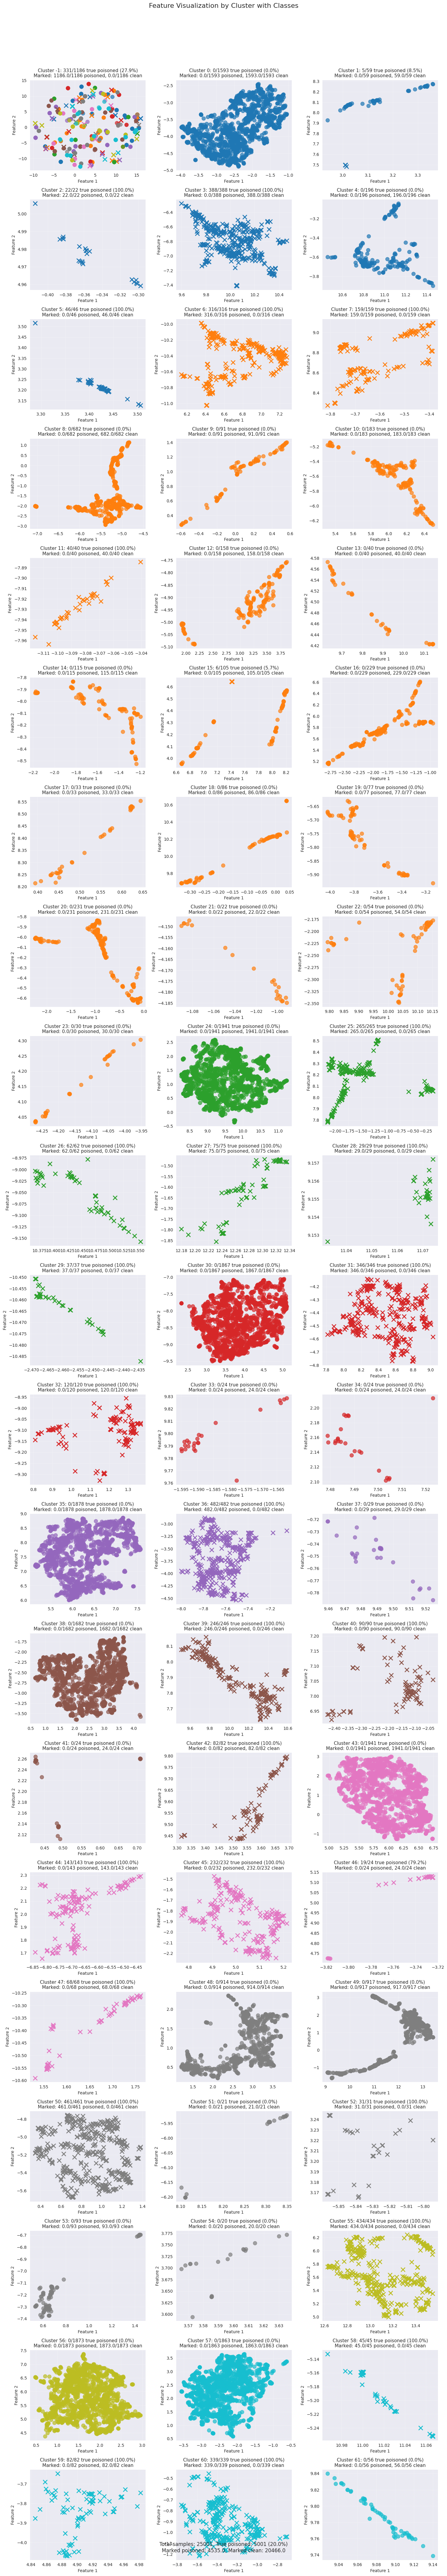

<Figure size 800x200 with 0 Axes>

In [25]:
import matplotlib.pyplot as plt
import numpy as np


def visualize_clusters_by_cluster(clusters_with_features, is_poison, class_labels, is_clean):
    """
    Visualize clusters with poisoned samples highlighted, with a separate plot for each cluster.
    Within each plot, colors represent different classes.

    Args:
        clusters_with_features: Output from get_clusters() method
                              - First n-1 columns are feature representations
                              - Last column contains cluster labels
        is_poison: Boolean array indicating which samples are poisoned (ground truth)
        class_labels: Array with class labels for each sample
        is_clean: Array of int values (1 or 0) indicating if a sample is classified as clean (1) or poisoned (0)
    """
    # Ensure is_poison is treated as boolean
    is_poison = np.array(is_poison, dtype=bool)

    # Extract features (first 2 columns) and cluster labels (last column)
    features = clusters_with_features[:, :2]  # Assuming 2D features
    cluster_labels = clusters_with_features[:, -1].astype(int)

    # Get unique clusters and classes
    unique_clusters = np.unique(cluster_labels)
    unique_classes = np.unique(class_labels)

    # Create a color map for classes
    class_colors = plt.cm.tab10(np.linspace(0, 1, len(unique_classes)))

    # Calculate figure size based on number of clusters
    n_cols = min(3, len(unique_clusters))  # Max 3 columns
    n_rows = int(np.ceil(len(unique_clusters) / n_cols))
    fig_width = n_cols * 5  # 5 inches per column
    fig_height = n_rows * 4  # 4 inches per row

    # Create a figure with subplots - one for each cluster
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))

    # Flatten axes for easier indexing
    if len(unique_clusters) > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    # Create a custom legend for sample types (poisoned vs benign)
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
               markersize=10, label='Benign Samples'),
        Line2D([0], [0], marker='x', color='k',
               markersize=10, linewidth=2, label='Poisoned Samples')
    ]

    # Add elements for class colors
    for i, class_label in enumerate(unique_classes):
        legend_elements.append(
            Line2D([0], [0], marker='o', color='w', markerfacecolor=class_colors[i],
                   markersize=10, label=f'Class {class_label}')
        )

    # Create legend in a separate figure
    fig_legend = plt.figure(figsize=(8, 2))
    fig_legend.legend(handles=legend_elements, loc='center', ncol=min(5, len(legend_elements)),
                      fontsize=12, frameon=True)
    fig_legend.tight_layout()

    # For debugging: print overall poison count
    print(f"Debug: Total poisoned samples in dataset: {np.sum(is_poison)} out of {len(is_poison)}")

    # Plot each cluster in its own subplot
    for i, cluster in enumerate(unique_clusters):
        ax = axes[i]

        # Get indices for this cluster
        cluster_indices = np.where(cluster_labels == cluster)[0]

        # For debugging: print poison count per cluster
        cluster_poison_count = np.sum(is_poison[cluster_indices])
        print(f"Debug: Cluster {cluster} has {cluster_poison_count} poisoned samples out of {len(cluster_indices)}")

        # Cluster statistics - ground truth
        cluster_total = len(cluster_indices)
        cluster_poisoned = np.sum(is_poison[cluster_indices])

        # Cluster statistics - detection results
        cluster_marked_clean = np.sum(is_clean[cluster_indices])
        cluster_marked_poison = cluster_total - cluster_marked_clean

        # Skip if there are no samples for this cluster
        if cluster_total == 0:
            ax.text(0.5, 0.5, f"No samples for cluster {cluster}",
                    ha='center', va='center', transform=ax.transAxes)
            continue

        # For each class, plot samples belonging to this cluster
        for j, class_label in enumerate(unique_classes):
            # Find samples that belong to both this cluster and this class
            cluster_class_indices = cluster_indices[class_labels[cluster_indices] == class_label]

            if len(cluster_class_indices) == 0:
                continue

            # Make sure we're using boolean indexing for is_poison
            is_poison_array = np.array(is_poison, dtype=bool)

            # Split into benign and poisoned
            benign_indices = cluster_class_indices[~is_poison_array[cluster_class_indices]]
            poison_indices = cluster_class_indices[is_poison_array[cluster_class_indices]]

            # Print for debugging
            if len(poison_indices) > 0:
                print(f"Debug: In cluster {cluster}, class {class_label} has {len(poison_indices)} poisoned samples")

            # Plot benign samples as circles
            if len(benign_indices) > 0:
                ax.scatter(
                    features[benign_indices, 0],
                    features[benign_indices, 1],
                    c=[class_colors[j]],
                    marker='o',
                    s=80,
                    alpha=0.7,
                    label=f'Class {class_label} (Benign)'
                )

            # Plot poisoned samples as x's with the same color
            if len(poison_indices) > 0:
                ax.scatter(
                    features[poison_indices, 0],
                    features[poison_indices, 1],
                    c=[class_colors[j]],
                    marker='x',
                    s=100,
                    linewidths=2,
                    alpha=1.0,
                    label=f'Class {class_label} (Poisoned)'
                )

        # Calculate poisoned percentage
        poison_percentage = (cluster_poisoned / cluster_total) * 100 if cluster_total > 0 else 0

        # Set title and labels for this subplot
        title = f'Cluster {cluster}: {cluster_poisoned}/{cluster_total} true poisoned ({poison_percentage:.1f}%)\n'
        title += f'Marked: {cluster_marked_poison}/{cluster_total} poisoned, {cluster_marked_clean}/{cluster_total} clean'

        ax.set_title(title, fontsize=11)
        ax.set_xlabel('Feature 1', fontsize=10)
        ax.set_ylabel('Feature 2', fontsize=10)
        ax.grid(True, alpha=0.3)

    # Hide unused subplots
    for i in range(len(unique_clusters), len(axes)):
        fig.delaxes(axes[i])

    # Add overall title
    fig.suptitle('Feature Visualization by Cluster with Classes', fontsize=16, y=1.02)

    # Add overall statistics for both ground truth and detection
    num_poison = np.sum(is_poison)
    num_total = len(is_poison)
    num_marked_clean = np.sum(is_clean)
    num_marked_poison = num_total - num_marked_clean

    poison_percentage = (num_poison / num_total) * 100 if num_total > 0 else 0

    stats_text = f'Total samples: {num_total}, True poisoned: {num_poison} ({poison_percentage:.1f}%)\n'
    stats_text += f'Marked poisoned: {num_marked_poison}, Marked clean: {num_marked_clean}'

    fig.text(0.5, 0.01, stats_text, ha='center', fontsize=12)

    # Adjust layout
    fig.tight_layout()

    return fig, fig_legend


# Example usage:
# Create visualization (now includes the is_clean parameter)
fig, fig_legend = visualize_clusters_by_cluster(clusters_with_features, is_poison_train, y_poisoned_train, is_clean_lst)

# Show the plots
plt.show()


[INFO] Loading variables into CCA...
[INFO] Extracting submodels...
[INFO] CCA object created successfully.


Starting performance measurement for: Poison Detection


[INFO] Clustering classes...
[INFO] Unique classes are: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
[INFO] Clustering class 0...
[INFO] Clustering class 1...
[INFO] Clustering class 2...
[INFO] Clustering class 3...
[INFO] Clustering class 4...
[INFO] Clustering class 5...
[INFO] Clustering class 6...
[INFO] Clustering class 7...
[INFO] Clustering class 8...
[INFO] Clustering class 9...
[INFO] Calculating real centroids...
[INFO] Calculating benign centroids...
[INFO] Target classes are: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
[INFO] Calculating misclassification rates...
[INFO] MR (k=0, i=0, |d|=0.5893449187278748)...


1/1 [==============================] - 0s 31ms/step


[WARNING] 5 out of the last 56 calls to <function _calculate_features at 0x7fd95711ad40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
[INFO] MR --> 0 , |f| = 16.438737869262695: 5 / 3618 = 0.0013819789939192924
[INFO] MR (k=0, i=0, |d|=0.5893449187278748) = 0.0013819789939192924
[INFO] MR (k=1, i=0, |d|=29.47182846069336)...


1/1 [==============================] - 0s 11ms/step


[INFO] MR --> 0 , |f| = 16.438737869262695: 113 / 3618 = 0.03123272526257601
[INFO] MR (k=1, i=0, |d|=29.47182846069336) = 0.03123272526257601
[INFO] MR (k=2, i=1, |d|=0.5122819542884827)...


1/1 [==============================] - 0s 12ms/step


[INFO] MR --> 1 , |f| = 16.377559661865234: 3 / 3508 = 0.0008551881413911061
[INFO] MR (k=2, i=1, |d|=0.5122819542884827) = 0.0008551881413911061
[INFO] MR (k=3, i=1, |d|=7.360095977783203)...


1/1 [==============================] - 0s 12ms/step


[INFO] MR --> 1 , |f| = 16.377559661865234: 5 / 3508 = 0.0014253135689851768
[INFO] MR (k=3, i=1, |d|=7.360095977783203) = 0.0014253135689851768
[INFO] MR (k=4, i=1, |d|=27.47036361694336)...


1/1 [==============================] - 0s 12ms/step


[INFO] MR --> 1 , |f| = 16.377559661865234: 257 / 3508 = 0.07326111744583809
[INFO] MR (k=4, i=1, |d|=27.47036361694336) = 0.07326111744583809
[INFO] MR (k=5, i=2, |d|=0.6849334239959717)...


1/1 [==============================] - 0s 12ms/step


[INFO] MR --> 2 , |f| = 15.844552993774414: 11 / 3617 = 0.0030411943599668234
[INFO] MR (k=5, i=2, |d|=0.6849334239959717) = 0.0030411943599668234
[INFO] MR (k=6, i=2, |d|=33.04806900024414)...


1/1 [==============================] - 0s 11ms/step


[INFO] MR --> 2 , |f| = 15.844552993774414: 358 / 3617 = 0.09897705280619298
[INFO] MR (k=6, i=2, |d|=33.04806900024414) = 0.09897705280619298
[INFO] MR (k=7, i=3, |d|=0.5555442571640015)...


1/1 [==============================] - 0s 11ms/step


[INFO] MR --> 3 , |f| = 15.724652290344238: 4 / 3592 = 0.0011135857461024498
[INFO] MR (k=7, i=3, |d|=0.5555442571640015) = 0.0011135857461024498
[INFO] MR (k=8, i=3, |d|=32.22027587890625)...


1/1 [==============================] - 0s 13ms/step


[INFO] MR --> 3 , |f| = 15.724652290344238: 276 / 3592 = 0.07683741648106904
[INFO] MR (k=8, i=3, |d|=32.22027587890625) = 0.07683741648106904
[INFO] MR (k=9, i=4, |d|=0.5271350145339966)...


1/1 [==============================] - 0s 11ms/step


[INFO] MR --> 4 , |f| = 15.82113265991211: 8 / 3576 = 0.0022371364653243847
[INFO] MR (k=9, i=4, |d|=0.5271350145339966) = 0.0022371364653243847
[INFO] MR (k=10, i=4, |d|=33.677406311035156)...


1/1 [==============================] - 0s 12ms/step


[INFO] MR --> 4 , |f| = 15.82113265991211: 282 / 3576 = 0.07885906040268456
[INFO] MR (k=10, i=4, |d|=33.677406311035156) = 0.07885906040268456
[INFO] MR (k=11, i=5, |d|=0.776247501373291)...


1/1 [==============================] - 0s 11ms/step


[INFO] MR --> 5 , |f| = 15.385605812072754: 11 / 3643 = 0.0030194894317869887
[INFO] MR (k=11, i=5, |d|=0.776247501373291) = 0.0030194894317869887
[INFO] MR (k=12, i=5, |d|=34.805355072021484)...


1/1 [==============================] - 0s 12ms/step


[INFO] MR --> 5 , |f| = 15.385605812072754: 206 / 3643 = 0.0565468020861927
[INFO] MR (k=12, i=5, |d|=34.805355072021484) = 0.0565468020861927
[INFO] MR (k=13, i=6, |d|=0.6689741015434265)...


1/1 [==============================] - 0s 11ms/step


[INFO] MR --> 6 , |f| = 16.297325134277344: 4 / 3605 = 0.0011095700416088765
[INFO] MR (k=13, i=6, |d|=0.6689741015434265) = 0.0011095700416088765
[INFO] MR (k=14, i=6, |d|=31.291114807128906)...


1/1 [==============================] - 0s 11ms/step


[INFO] MR --> 6 , |f| = 16.297325134277344: 117 / 3605 = 0.03245492371705964
[INFO] MR (k=14, i=6, |d|=31.291114807128906) = 0.03245492371705964
[INFO] MR (k=15, i=7, |d|=0.44246232509613037)...


1/1 [==============================] - 0s 11ms/step


[INFO] MR --> 7 , |f| = 15.780776023864746: 10 / 3591 = 0.00278473962684489
[INFO] MR (k=15, i=7, |d|=0.44246232509613037) = 0.00278473962684489
[INFO] MR (k=16, i=7, |d|=37.023677825927734)...


1/1 [==============================] - 0s 12ms/step


[INFO] MR --> 7 , |f| = 15.780776023864746: 1247 / 3591 = 0.34725703146755776
[INFO] MR (k=16, i=7, |d|=37.023677825927734) = 0.34725703146755776
[INFO] MR (k=17, i=8, |d|=0.5328798294067383)...


1/1 [==============================] - 0s 12ms/step


[INFO] MR --> 8 , |f| = 15.848187446594238: 8 / 3649 = 0.0021923814743765417
[INFO] MR (k=17, i=8, |d|=0.5328798294067383) = 0.0021923814743765417
[INFO] MR (k=18, i=8, |d|=29.83428382873535)...


1/1 [==============================] - 0s 12ms/step


[INFO] MR --> 8 , |f| = 15.848187446594238: 503 / 3649 = 0.13784598520142505
[INFO] MR (k=18, i=8, |d|=29.83428382873535) = 0.13784598520142505
[INFO] MR (k=19, i=9, |d|=0.9369954466819763)...


1/1 [==============================] - 0s 12ms/step


[INFO] MR --> 9 , |f| = 15.763494491577148: 12 / 3601 = 0.0033324076645376284
[INFO] MR (k=19, i=9, |d|=0.9369954466819763) = 0.0033324076645376284
[INFO] MR (k=20, i=9, |d|=27.551055908203125)...


1/1 [==============================] - 0s 11ms/step


[INFO] MR --> 9 , |f| = 15.763494491577148: 296 / 3601 = 0.08219938905859484
[INFO] MR (k=20, i=9, |d|=27.551055908203125) = 0.08219938905859484
[INFO] Evaluating cluster misclassification...
[INFO] Cluster k=4 i=1 considered poison (0.07326111744583809 >= 0.94)
[INFO] Cluster k=6 i=2 considered poison (0.09897705280619298 >= 0.94)
[INFO] Cluster k=8 i=3 considered poison (0.07683741648106904 >= 0.94)
[INFO] Cluster k=10 i=4 considered poison (0.07885906040268456 >= 0.94)
[INFO] Cluster k=16 i=7 considered poison (0.34725703146755776 >= 0.94)
[INFO] Cluster k=18 i=8 considered poison (0.13784598520142505 >= 0.94)
[INFO] Cluster k=20 i=9 considered poison (0.08219938905859484 >= 0.94)



Performance Summary for Poison Detection:
Execution Time: 5.90 seconds
duration_seconds: 5.87
cpu_percent_mean: 144.57
cpu_percent_max: 898.90
memory_mb_mean: 2641.48
memory_mb_max: 2691.97
gpu_percent_mean: 24.04
gpu_percent_max: 93.00
gpu_memory_mb_mean: 7416.39
gpu_memory_mb_max: 7416.99


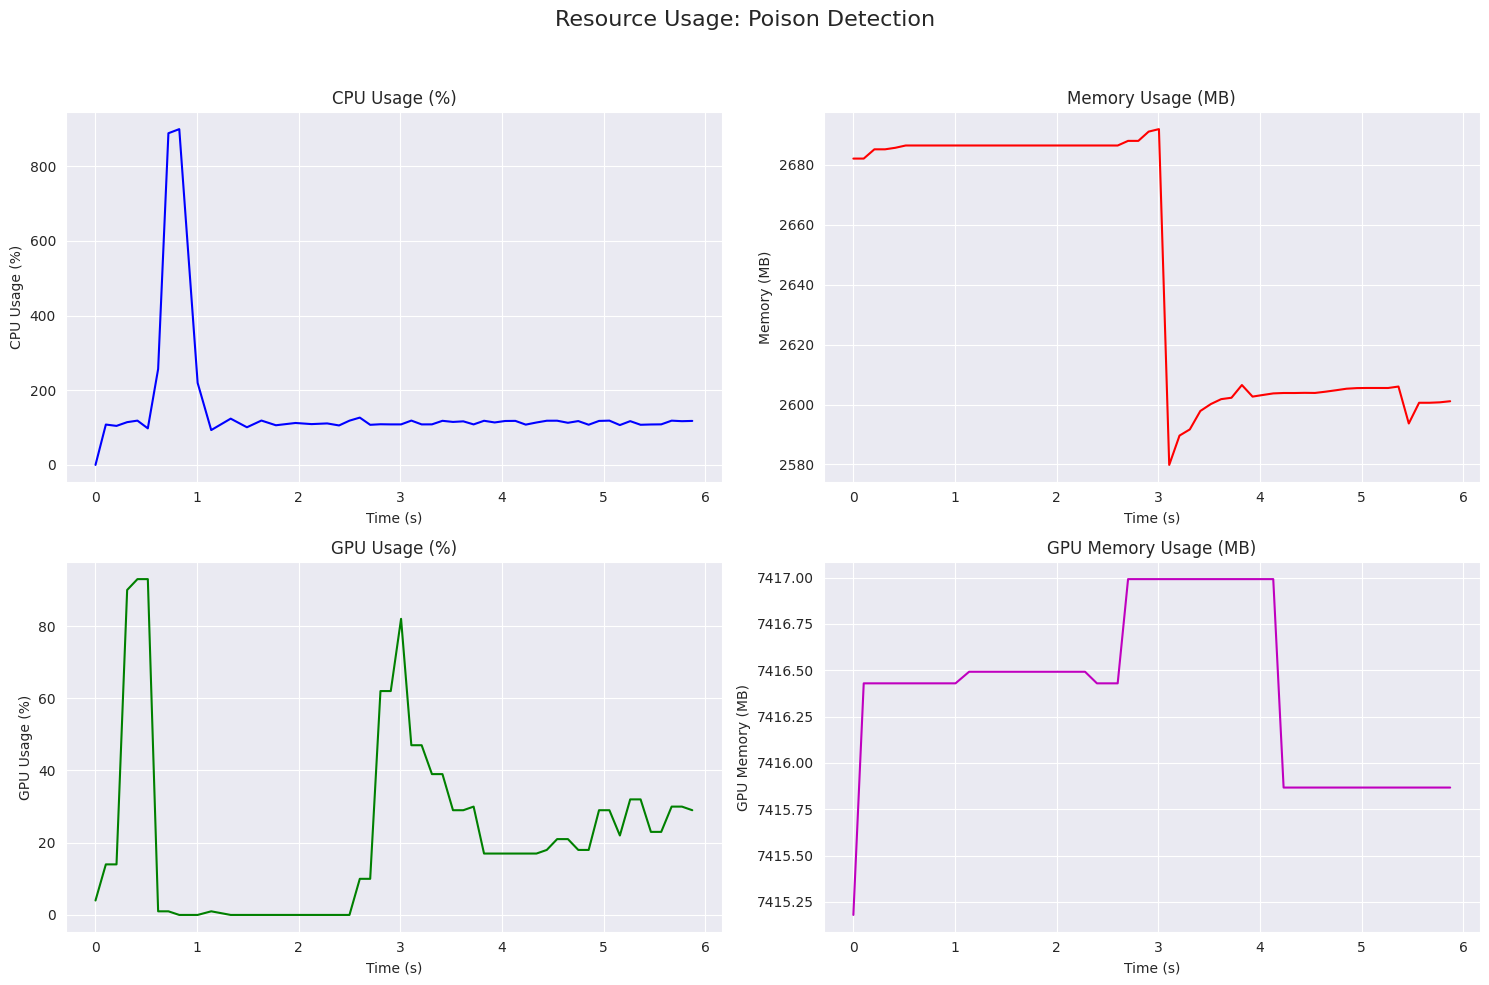

In [26]:
sample_percentage = 0.4
benign_test_indices = np.where(is_poison_test == 0)[0]
sample_size = int(sample_percentage * len(benign_test_indices))
sample_indices = np.random.choice(len(benign_test_indices), size=sample_size, replace=False)
benign_sample = benign_test_indices[sample_indices]

defence = ClusteringCentroidAnalysis(classifier, x_poisoned_test, y_poisoned_test, benign_sample, "dense_1", misclassification_threshold=0.06)

with PerformanceTimer(task_name="Poison Detection", plot=True, save_data=False) as timer_ccaud:
    report, is_clean_lst = defence.detect_poison()


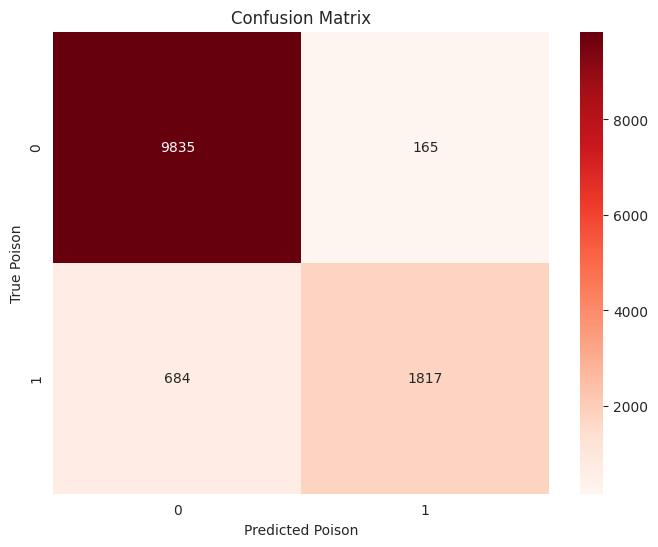

              precision    recall  f1-score   support

           0     0.9350    0.9835    0.9586     10000
           1     0.9168    0.7265    0.8106      2501

    accuracy                         0.9321     12501
   macro avg     0.9259    0.8550    0.8846     12501
weighted avg     0.9313    0.9321    0.9290     12501



In [27]:

from sklearn.metrics import confusion_matrix

is_poisoned_lst = 1 - is_clean_lst.astype('int32')
poison_confusion_matrix = confusion_matrix(is_poison_test, is_poisoned_lst)
plt.figure(figsize=(8, 6))

sns.heatmap(poison_confusion_matrix, annot=True, fmt="d", cmap="Reds")
plt.xlabel("Predicted Poison")
plt.ylabel("True Poison")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(is_poison_test, is_poisoned_lst, digits=4)
print(report)

### Evaluate Defense

In [28]:
# Evaluate method when ground truth is known:
print("------------------- Results using size metric -------------------")
is_clean = (is_poison_train == 0)
confusion_matrix = defence.evaluate_defence(is_clean[shuffled_indices])

jsonObject = json.loads(confusion_matrix)
for label in jsonObject:
    print(label)
    pprint.pprint(jsonObject[label]) 

------------------- Results using size metric -------------------
class_0
{'FalseNegative': {'denominator': 238, 'numerator': 228, 'rate': 95.8},
 'FalsePositive': {'denominator': 987, 'numerator': 15, 'rate': 1.52},
 'TrueNegative': {'denominator': 987, 'numerator': 972, 'rate': 98.48},
 'TruePositive': {'denominator': 238, 'numerator': 10, 'rate': 4.2}}
class_1
{'FalseNegative': {'denominator': 279, 'numerator': 223, 'rate': 79.93},
 'FalsePositive': {'denominator': 1140, 'numerator': 236, 'rate': 20.7},
 'TrueNegative': {'denominator': 1140, 'numerator': 904, 'rate': 79.3},
 'TruePositive': {'denominator': 279, 'numerator': 56, 'rate': 20.07}}
class_2
{'FalseNegative': {'denominator': 251, 'numerator': 192, 'rate': 76.49},
 'FalsePositive': {'denominator': 1039, 'numerator': 208, 'rate': 20.02},
 'TrueNegative': {'denominator': 1039, 'numerator': 831, 'rate': 79.98},
 'TruePositive': {'denominator': 251, 'numerator': 59, 'rate': 23.51}}
class_3
{'FalseNegative': {'denominator': 250,

### Get clustering and reduce activations to 3 dimensions using PCA

In [29]:
clusters_by_class, _ = defence.cluster_activations()

defence.set_params(ndims=3)
_, red_activations_by_class = defence.cluster_activations()

AttributeError: 'ClusteringCentroidAnalysis' object has no attribute 'cluster_activations'

### Visualize activations colored by clustering

In [ ]:
c = 0
red_activations = red_activations_by_class[c]
clusters = clusters_by_class[c]
fig = plt.figure()
ax = plt.axes(projection='3d')
colors=["#0000FF", "#00FF00"]
for i, act in enumerate(red_activations):
    ax.scatter3D(act[0], act[1], act[2], color = colors[clusters[i]])

In [ ]:
def plot_class_clusters(n_class, n_clusters):
    for q in range(n_clusters):
        plt.figure(1, figsize=(25, 25))
        plt.tight_layout()
        plt.subplot(1, n_clusters, q + 1)
        plt.title("Class "+ str(n_class)+ ", Cluster " + str(q), fontsize=40)
        sprite = sprites_by_class[n_class][q]
        plt.imshow(sprite, interpolation='none')
        
sprites_by_class = defence.visualize_clusters(x_train, save=False)

# Visualize clusters for class 1
print("Clusters for class 1.")
print("Note that one of the clusters contains the poisonous data for this class.")
print("Also, legitimate number of data points are less (see relative size of digits)")
plot_class_clusters(1, 2)

In [ ]:
print("Clusters for class 5:")
plot_class_clusters(5, 2)

## Activation Defense (with exclusionary reclassification)

In [ ]:
# Here we use exclusionary reclassification, which will also relabel the data internally
defence = ActivationDefence(classifier, x_train, y_train, ex_re_threshold=1)

In [ ]:
report, is_clean_lst = defence.detect_poison(nb_clusters=2, nb_dims=10, reduce="PCA")

In [ ]:
print("Analysis completed. Report:")
pprint.pprint(report)

### Evaluate Defence

In [ ]:
# Evaluate method when ground truth is known:
print("------------------- Results using size metric -------------------")
is_clean = (is_poison_train == 0)
cm = defence.evaluate_defence(is_clean[shuffled_indices])

jsonObject = json.loads(cm)
for label in jsonObject:
    print(label)
    pprint.pprint(jsonObject[label]) 

### Get clustering and reduce activations to 3 dimensions using PCA

In [ ]:
clusters_by_class, _ = defence.cluster_activations()

defence.set_params(ndims=3)
_, red_activations_by_class = defence.cluster_activations()

### Visualize activations colored by clustering

In [ ]:
c = 0
red_activations = red_activations_by_class[c]
clusters = clusters_by_class[c]
fig = plt.figure()
ax = plt.axes(projection='3d')
colors=["#0000FF", "#00FF00"]
for i, act in enumerate(red_activations):
    ax.scatter3D(act[0], act[1], act[2], color = colors[clusters[i]])

In [ ]:
def plot_class_clusters(n_class, n_clusters):
    for q in range(n_clusters):
        plt.figure(1, figsize=(25, 25))
        plt.tight_layout()
        plt.subplot(1, n_clusters, q+1)
        plt.title("Class "+ str(n_class)+ ", Cluster " + str(q), fontsize=40)
        sprite = sprites_by_class[n_class][q]
        plt.imshow(sprite, interpolation='none')
        
sprites_by_class = defence.visualize_clusters(x_train, save=False)

# Visualize clusters for class 1
print("Clusters for class 1.")
print("Note that one of the clusters contains the poisonous data for this class.")
print("Also, legitimate number of data points are less (see relative size of digits)")
plot_class_clusters(1, 2)

In [ ]:
print("Clusters for class 5:")
plot_class_clusters(5, 2)